<a href="https://colab.research.google.com/github/violetyousif/DeepFakeDetector/blob/main/FinalProject_VioletYousif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Fakes Images using Convolutional Neural Networks

Violet Yousif

In [ ]:
from __future__ import absolute_import, division, print_function

import os
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpmig

%matplotlib inline

# Retreiving Image Files from Directory

[Tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

Setting Up Google Drive and Loading Dataset: Mounting Google Drive for file retrieval and examining the dataset structure.

Visualizing real and fake image directories and counting the number of images per class.

Then, displaying dataset information for further analysis.

In [ ]:
# Mounting google drive for file retrieval
from google.colab import drive
drive.mount('/content/drive')
main_folder = "/content/drive/My Drive/ColabNotebooks/FinalProject"
subfolder = main_folder + "/largedataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_folder = "/content/drive/My Drive/ColabNotebooks/FinalProject"
subfolder = main_folder + "/archive"
img_folders = os.path.join(main_folder + "/largedataset/train")
# Load the CSV file and print head of each label name
dataset = pd.read_csv(subfolder + "/data.csv")
dataset.head()

# Load Real and Fake Images for training
img_real = os.path.join(img_folders + "/real/")
img_fake = os.path.join(img_folders + "/fake/")

# List example names from each directory
real_names = os.listdir(img_real)
print("\n", real_names[:10], "\n")
fake_names = os.listdir(img_fake)
print(fake_names[:10], "\n")

# Count the number of found images per destination
print("Total Images + test:", len(dataset))
print("Total Real Images:  ", len(real_names))
print("Total Fake Images:  ", len(fake_names), "\n")

# Prints range index: n # of entries, range values [0,n],
# and details per name object
dataset.info()


 ['real_48828.jpg', 'real_53091.jpg', 'real_43881.jpg', 'real_53240.jpg', 'real_42910.jpg', 'real_44322.jpg', 'real_48049.jpg', 'real_45831.jpg', 'real_45786.jpg', 'real_51477.jpg'] 

['fake_PMQL85Q7LP.jpg', 'fake_NT9LBODCHS.jpg', 'fake_RWAH4BYNC8.jpg', 'fake_RPKX5LH6I0.jpg', 'fake_NTQ6DBU48U.jpg', 'fake_QJTHSXA99F.jpg', 'fake_RA0EJYBFVG.jpg', 'fake_QGNIO38NXV.jpg', 'fake_QGALE1BQKM.jpg', 'fake_QO4M2VXC9I.jpg'] 

Total Images + test: 1289
Total Real Images:   3500
Total Fake Images:   3500 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   images_id  1289 non-null   object
 1   label      1289 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


# Prepare Key Terms

In [ ]:
# Declare dimensions of images (300x300)
HEIGHT = 160
WIDTH = 160

# Set training parameters
LEARNING_RATE = 0.001      # Model optimizer learning rate
BATCH_SIZE = 32           # Number of training samples in a batch

# For grid plots
nrows = 5
ncols = 5

# Visualization of Data

This section generates a grid of real and fake images randomly selected from their directories. Each grid contains a 5x5 array of images with titles indicating whether they are real or fake. This visualization provides a glimpse into the dataset's content and helps in understanding the characteristics of real and fake images.

In [ ]:
# Data visualizations

def plot_image(folder, names):
    pic_index = np.random.randint(0, len(names))
    img_path = os.path.join(folder, names[pic_index])
    img = mpmig.imread(img_path)
    plt.axis('Off')
    plt.imshow(img)

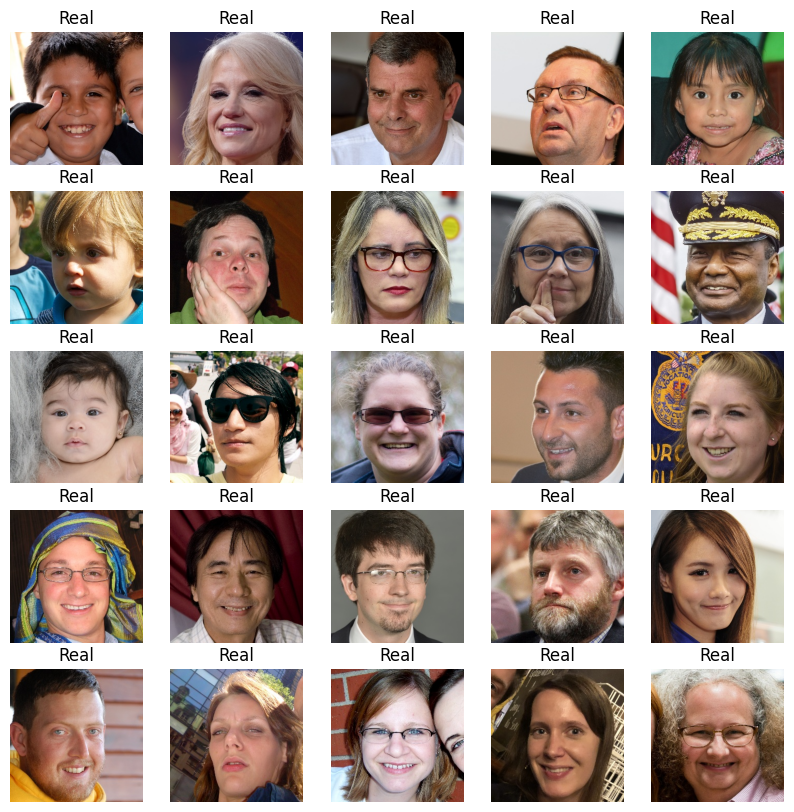

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.title('Real')
    plot_image(img_real, real_names)

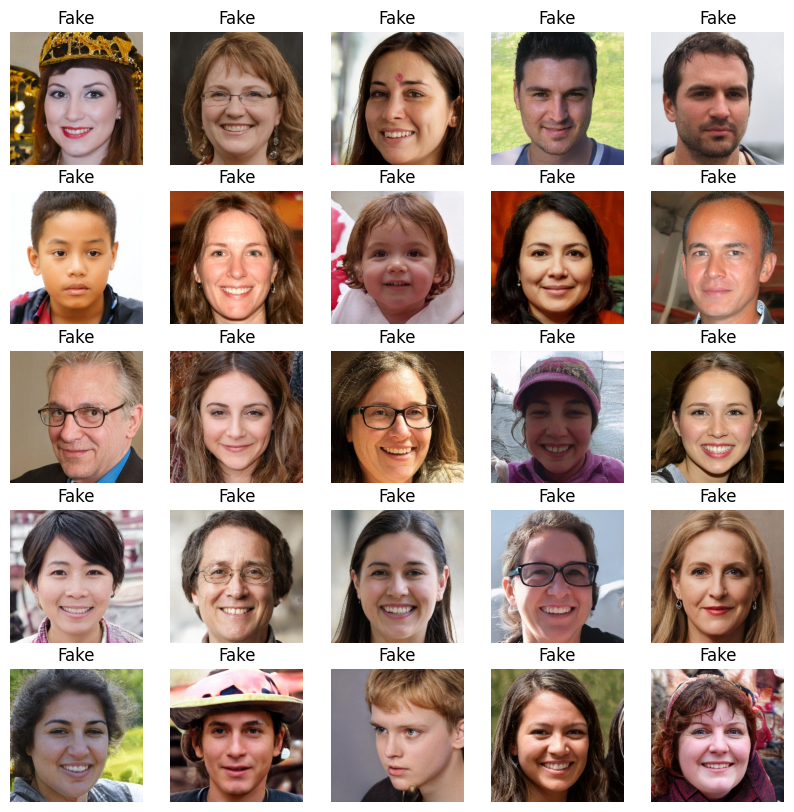

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.title('Fake')
    plot_image(img_fake, fake_names)

# Preprocessing and Image Configuration

This code snippet utilizes TensorFlow's image_dataset_from_directory function to create datasets for training and validation from image directories. It loads images from specified directories, shuffles them, and organizes them into batches for efficient training and validation processes.

In [ ]:
valid_folder = os.path.join(main_folder + "/largedataset/valid")
test_folder = os.path.join(main_folder + "/largedataset/test/")

training = tf.keras.utils.image_dataset_from_directory(
    img_folders,
    shuffle=True,
    batch_size=int(BATCH_SIZE),
    image_size=(HEIGHT, WIDTH)
)
validation = tf.keras.utils.image_dataset_from_directory(
    valid_folder,
    shuffle=True,
    batch_size=int(BATCH_SIZE),
    image_size=(HEIGHT, WIDTH)
)

Found 7000 files belonging to 2 classes.
Found 3000 files belonging to 2 classes.


## Print Sample of Training Set

Displays the training set with both folder's images to display samples of its original images.

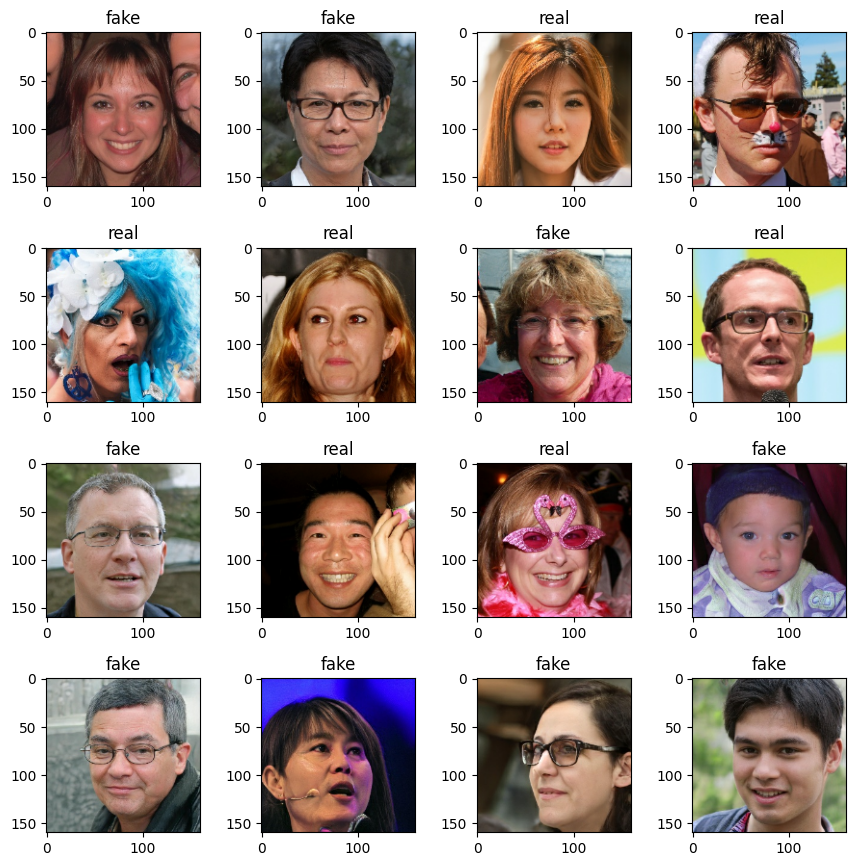

In [ ]:
class_names = training.class_names

plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Prepare Batches
This code divides a dataset into training, validation, and test sets, prefetching data to optimize performance. It also splits the validation set further into a smaller test set, ensuring better model evaluation.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation)
test_set = validation.take(val_batches // 5)
validation_set = validation.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of validation batches: 76
Number of test batches: 18


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

training_set = training.prefetch(buffer_size=AUTOTUNE)
validation = validation_set.prefetch(buffer_size=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

## Create Transformations for Training Data

The code below demonstrates image data augmentation techniques using TensorFlow's Keras Sequential API. It applies a series of random transformations such as flips, rotations, zooms, contrasts, translations, and brightness adjustments to enhance the diversity of the training dataset.

The augmented images are then visualized using 1 photo to showcase the effect of these transformations on multiple instances of the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomBrightness([-0.6,0.6]),
])

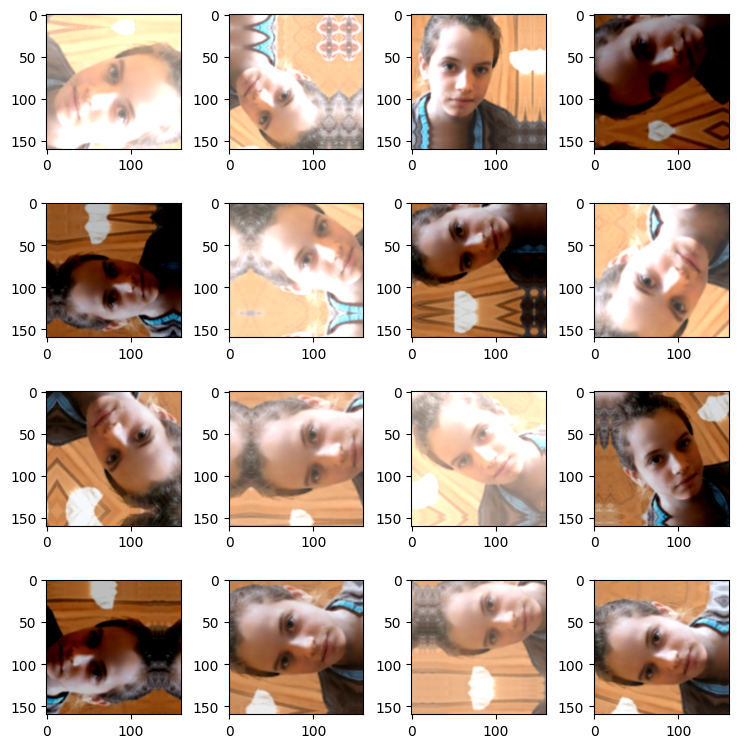

In [ ]:
for image, _ in training_set.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.8, wspace=0.2, hspace=0.4)
plt.show()

# Preprocessing
This code sets up a pretrained EfficientNetV2B0 model for transfer learning. It includes preprocessing input data using the EfficientNet V2 specific function and rescales pixel values to the range [-1, 1]. The model's architecture is instantiated with ImageNet weights, excluding the top classification layer. After processing a batch of images through the model, it freezes the base layers to prevent further training. The summary provides an overview of the model's architecture.

In [ ]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255, offset=-1)    # [-1,1]

IMG_SHAPE = (HEIGHT,WIDTH) + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 160, 160, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 160, 160, 3)          0         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 80, 80, 32)           864       ['normalizatio

# Prediction Shape Analysis and Feature Extraction
This code snippet computes the shape of the average feature batch obtained from a Global Average Pooling 2D layer, which is typically used to reduce spatial dimensions while retaining important features. Subsequently, it shapes the prediction batch using a Dense layer with a Sigmoid activation function, which is commonly employed for binary classification tasks. The output shape reflects the application of the Sigmoid activation function to the feature batch averages.

In [ ]:
# Get the shape of the average feature batch
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Get the shape of the prediction batch using Sigmoid activation
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


This code constructs a TensorFlow Keras model for image classification. It defines the input shape, applies data augmentation and preprocessing, passes the data through a pre-trained base model with frozen layers, adds a global average pooling layer, applies dropout for regularization, and finally, generates predictions using a dense layer with a sigmoid activation function. The model summary provides an overview of its architecture and layer configurations.

**Total Parameters:** The total number of parameters in the model is 5,920,593, which includes both trainable and non-trainable parameters.

**Trainable Parameters:** The number of parameters that are trainable is 1,281, while the rest are non-trainable. These trainable parameters are associated with the dense layer's weights and biases.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

The first line computes the number of trainable variables in the model, indicating the count of parameters that will be updated during training.

The second line generates a visualization of the model's architecture, including the flow of data through different layers and their respective shapes.

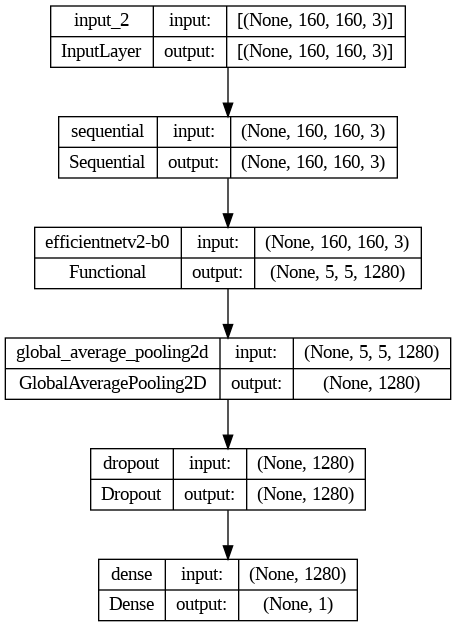

In [ ]:
len(model.trainable_variables)

tf.keras.utils.plot_model(model, show_shapes=True)

This code configures the model for training by specifying the optimization algorithm, loss function, and evaluation metrics. It uses the Adam optimizer with a learning rate of 0.001, binary cross-entropy as the loss function for binary classification tasks, and binary accuracy as the evaluation metric to monitor during training.

In [ ]:
# Learning rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

This code snippet demonstrates the initialization of layers in a neural network model using Keras. It first creates a Dense layer with 3 units and builds its weights based on an input shape of (None, 4). Then, it prints the total number of weights, trainable weights, and nontrainable weights in the layer. Next, it creates a BatchNormalization layer, builds its weights similarly, and prints the corresponding weight counts.

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0
weights: 4
trainable_weights: 2
non_trainable_weights: 2


This code defines a sequential TensorFlow model for image classification. It comprises several convolutional and dense layers with ReLU activation functions, max-pooling layers for downsampling, and a dropout layer for regularization. The model ends with a dense layer with a single neuron and a sigmoid activation function for binary classification followed by the summary provides insights into the architecture, including the number of parameters and output shapes at each layer.

In [ ]:
# Second tensorflow model

model = tf.keras.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
  layers.MaxPool2D((2, 2)),
  layers.Dense(128, activation='relu'),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPool2D((2, 2)),
  layers.Dense(32, activation='relu'),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPool2D((2, 2)),
  layers.Dense(32, activation='relu'),
  layers.Flatten(),
  #layers.Dense(32, activation='relu'),
  layers.Dropout(rate = 0.2),
  layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 dense_2 (Dense)             (None, 79, 79, 128)       4224      
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

This code configures a TensorFlow model for training using RMSprop optimizer with a learning rate of 0.001, binary cross-entropy loss function, and accuracy as the evaluation metric. It then evaluates the model's initial performance on the validation set and prints the initial loss and accuracy values.

In [ ]:
LEARNING_RATE = 1e-3
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_set)

print("Initial Loss: {:.4f}".format(loss0))
print("Initial Accuracy: {:.4f}".format(accuracy0))

76/76 [==============================] - 6s 42ms/step - loss: 2.3566 - accuracy: 0.5103
Initial Loss: 2.3566
Initial Accuracy: 0.5103


This code trains the TensorFlow model on the training dataset for a specified number of epochs (initial_epochs) while validating on the validation dataset after each epoch. The training progress, including loss and accuracy metrics on both training and validation sets, is stored in the history object for further analysis.

In [ ]:
history = model.fit(training_set,
                    epochs=initial_epochs,
                    validation_data=validation_set)

Epoch 1/10
219/219 [==============================] - 17s 58ms/step - loss: 1.2292 - accuracy: 0.5461 - val_loss: 0.6411 - val_accuracy: 0.6564
Epoch 2/10
219/219 [==============================] - 12s 54ms/step - loss: 0.6407 - accuracy: 0.6621 - val_loss: 0.6116 - val_accuracy: 0.6630
Epoch 3/10
219/219 [==============================] - 12s 55ms/step - loss: 0.5879 - accuracy: 0.7166 - val_loss: 0.5993 - val_accuracy: 0.7384
Epoch 4/10
219/219 [==============================] - 12s 54ms/step - loss: 0.5111 - accuracy: 0.7560 - val_loss: 0.5251 - val_accuracy: 0.7500
Epoch 5/10
219/219 [==============================] - 12s 54ms/step - loss: 0.4571 - accuracy: 0.7896 - val_loss: 0.4847 - val_accuracy: 0.7756
Epoch 6/10
219/219 [==============================] - 12s 55ms/step - loss: 0.4255 - accuracy: 0.8067 - val_loss: 0.6240 - val_accuracy: 0.7092
Epoch 7/10
219/219 [==============================] - 12s 55ms/step - loss: 0.4000 - accuracy: 0.8211 - val_loss: 0.4838 - val_accuracy:

This code visualizes the training and validation performance of a TensorFlow model over epochs. It plots the training and validation accuracy in the upper subplot and the training and validation loss in the lower subplot. These visualizations provide insights into the model's learning progress and help identify potential issues such as overfitting or underfitting.

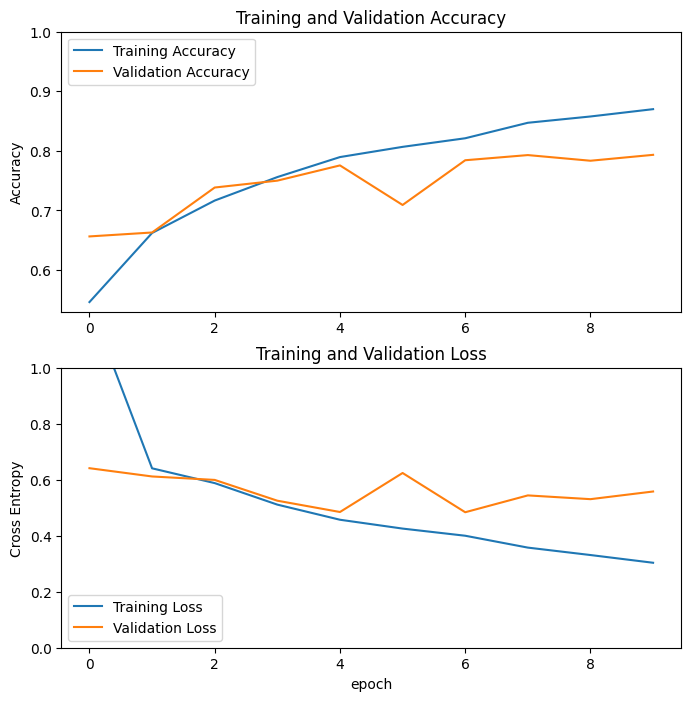

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-Tune Data
This code snippet enables fine-tuning of a pre-trained base model by allowing certain layers to be trainable while freezing others. It specifies the number of layers to fine-tune from, freezes the layers before this point, and compiles the model using RMSprop optimizer with a reduced learning rate. The summary displays the updated trainable and non-trainable parameters after fine-tuning.

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  270


Compiles the model with a new learning rate and prints a summary of the updated model architecture.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE/2),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 dense_2 (Dense)             (None, 79, 79, 128)       4224      
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

This code calculates the number of trainable variables in the model and then evaluates its performance on a test dataset, providing the test accuracy and loss as metrics. These metrics offer insights into how well the model generalizes to unseen data.

In [ ]:
len(model.trainable_variables)

loss, accuracy = model.evaluate(test_set)

print("Test accuracy: {:.4f}".format(accuracy))
print("Test loss: {:.4f}".format(loss))

18/18 [==============================] - 1s 37ms/step - loss: 0.4759 - accuracy: 0.8264
Test accuracy: 0.8264
Test loss: 0.4759


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_set)

Epoch 11/20
219/219 [==============================] - 14s 55ms/step - loss: 0.2128 - accuracy: 0.9119 - val_loss: 0.6052 - val_accuracy: 0.8069
Epoch 12/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1742 - accuracy: 0.9319 - val_loss: 0.5852 - val_accuracy: 0.8156
Epoch 13/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1505 - accuracy: 0.9396 - val_loss: 0.6085 - val_accuracy: 0.8164
Epoch 14/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1318 - accuracy: 0.9483 - val_loss: 0.6402 - val_accuracy: 0.8160
Epoch 15/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1260 - accuracy: 0.9513 - val_loss: 0.6739 - val_accuracy: 0.8197
Epoch 16/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1111 - accuracy: 0.9550 - val_loss: 0.6932 - val_accuracy: 0.8205
Epoch 17/20
219/219 [==============================] - 12s 55ms/step - loss: 0.1013 - accuracy: 0.9584 - val_loss: 0.6630 - val_ac

This plot visualizes the training and validation performance of the model before and after fine-tuning. It plots the combined training and validation accuracy in the upper subplot and the combined training and validation loss in the lower subplot. Additionally, it marks the point where fine-tuning starts with a vertical line for better interpretation of the results.

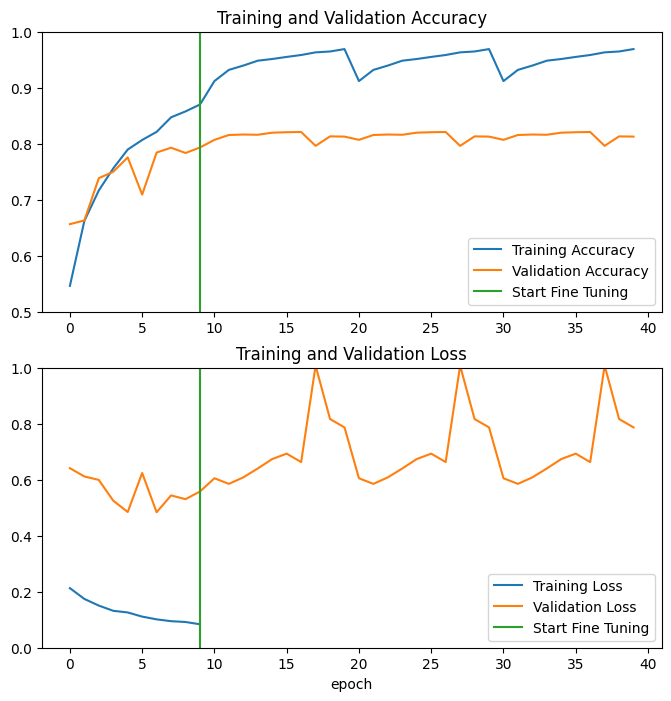

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This code generates a heatmap visualization of the accuracy values over epochs during training. It reshapes the accuracy data into a 2D array for visualization and displays it using a color map ('viridis') to represent the accuracy values. The heatmap provides a clear visual representation of how accuracy changes over epochs, aiding in the analysis of model training progress.

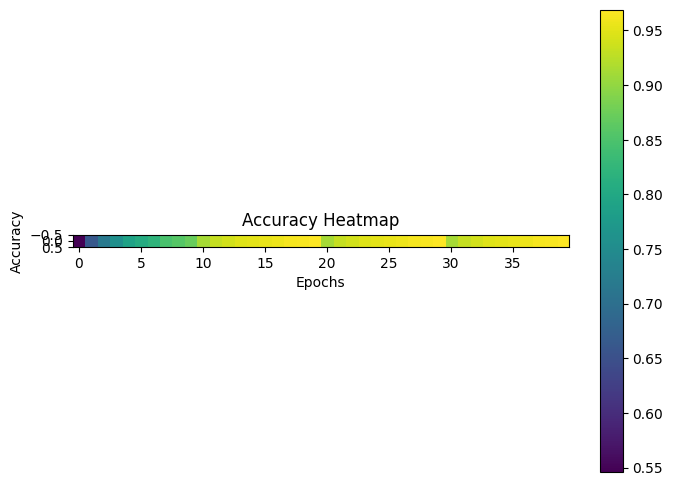

In [ ]:
# Plot heatmap
plt.figure(figsize=(8, 6))
accuracy_data = history.history['accuracy']
accuracy_data = np.array(accuracy_data).reshape((1, -1))
plt.imshow(accuracy_data, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Accuracy Heatmap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1]


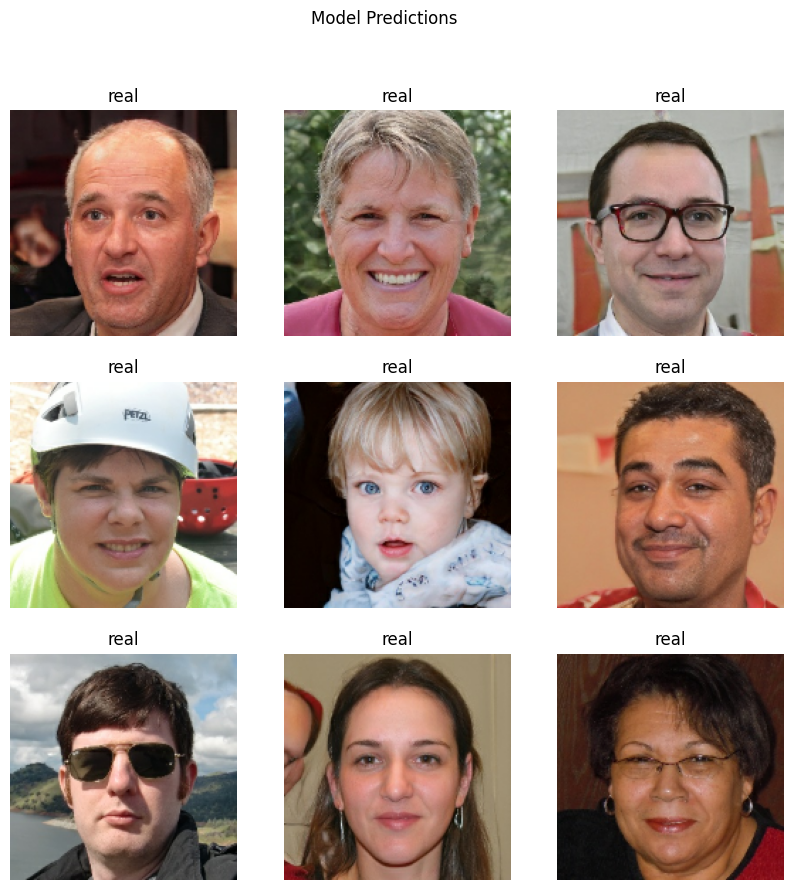

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
percent = tf.nn.sigmoid(predictions)
predictions = tf.where(percent < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
  plt.suptitle("Model Predictions")


The model is compiled using the binary crossentropy loss function, Adam optimizer, and accuracy metric. The summary of the model architecture, including the layers, parameters, and output shapes, is displayed.

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 dense_2 (Dense)             (None, 79, 79, 128)       4224      
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                 

# Train Model
This code snippet prints the compiled metrics, loss function, and optimizer used in the model for verification.

In [ ]:
# print(model.compiled_metrics)
# print(model.loss)
# print(model.optimizer)

binary_crossentropy


This code prints the values of the class indices from train_gen. These indices map the class labels to their corresponding integer representations, which are used internally by the model during training.


The model is trained using the fit method with the training generator train_gen for 20 epochs. Validation data from validate_gen is used to validate the model's performance during training. The number of steps per epoch and validation steps are set based on the lengths of the respective generators.

The model is evaluated using the evaluate method with the training generator train_gen. The test loss and accuracy are printed. Additionally, the training history, including loss and accuracy metrics for each epoch, is displayed.

In [ ]:

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title("Loss at each epoch")
# plt.legend(labels=['Training', 'Validation'])
# plt.show()

In [ ]:
# print(f"Length of history.epoch: {len(history.epoch)}")
# print(f"Length of accuracy_data: {len(accuracy_data)}")
# print(f"Length of history.history['val_accuracy']: {len(history.history['val_accuracy'])}")


Length of history.epoch: 20
Length of accuracy_data: 1
Length of history.history['val_accuracy']: 20


#Testing Data

This code snippet randomly shuffles the filenames of images located in a directory. This randomization process is commonly used to ensure unbiased evaluation and testing of machine learning models.

In [ ]:
# import random

In [ ]:
# #folder_path = "/content/drive/My Drive/ColabNotebooks/FinalProject/test3/"
# test_folder = os.path.join(subfolder + "/test")

# test_names = os.listdir(test_folder)
# random.shuffle(test_names)

# Visualize Test Data
This code snippet displays a grid of images using Matplotlib, where each subplot is assigned a title label based on whether the image filename starts with a digit or not. If the filename starts with a digit, it is labeled as 'Real'; otherwise, it is labeled as 'Fake'. The images are plotted using a custom function plot_image, providing visual insight into the dataset's content.

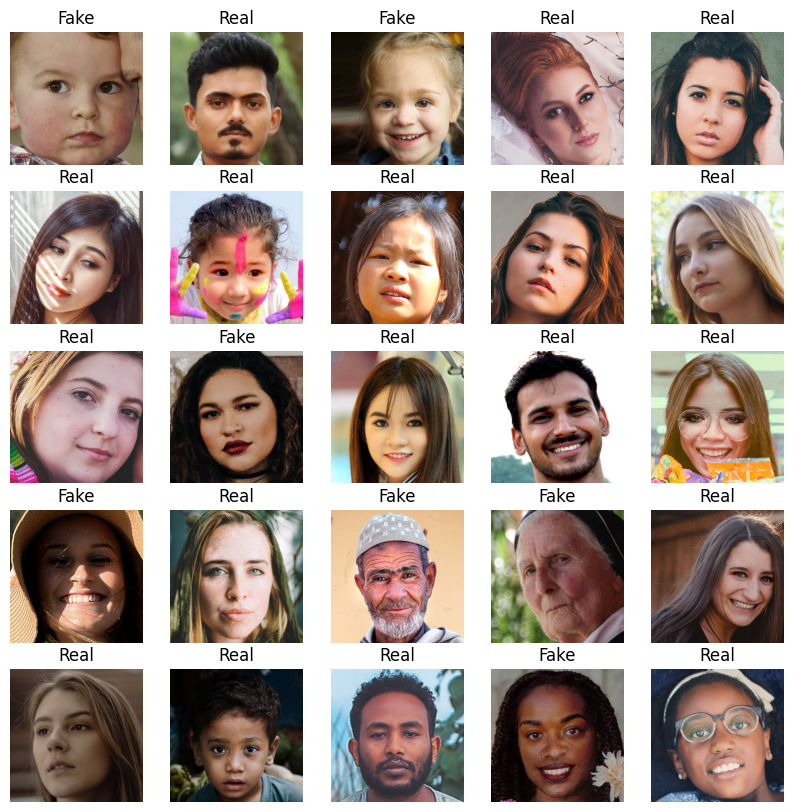

In [ ]:
# plt.figure(figsize=(10, 10))
# for i in range(nrows*ncols):
#   ax = plt.subplot(nrows, ncols, i+1)

#   file_name = test_names[i]
#   filename_without_extension = file_name.split('.')[0]

#   #check_name = int(filename_without_extension)
#   if file_name[0].isdigit():
#     plt.title('Real')
#   else:
#     plt.title('Fake')

#   plot_image(test_folder, test_names)


# Preprocess Data
This code snippet prepares test data using an ImageDataGenerator with rescaling. Images are loaded from the directory specified by folder_path and resized to the dimensions (HEIGHT, WIDTH). The data is batched with a specified batch size and labeled using binary class mode. The generator is set to shuffle the data for unbiased evaluation during testing.

In [ ]:
# testing_data = ImageDataGenerator(rescale=1./255)

# testing_gen = testing_data.flow_from_directory(
#     directory = folder_path,
#     target_size = (HEIGHT, WIDTH),
#     batch_size = BATCH_SIZE,
#     class_mode = 'binary',
#     shuffle = True,
# )

Found 0 images belonging to 0 classes.


# Testing model against test data
Option to shuffle images again without rerunning above processes.

In [ ]:
# # Randomize again for testing
# random.shuffle(test_names)

This code snippet performs testing on a subset of test images by loading and displaying the images, making predictions using the trained model, and comparing the actual labels (real vs. fake) with the model's predictions. The subset of test images is randomly selected and visualized along with their actual and predicted labels, providing insight into the model's performance on unseen data.

Total Test Images: 453 

['fake_70.jpg', '849.jpg', '822.jpg', 'fake_36.jpg', '846.jpg', 'fake_497.jpg', '890.jpg', 'fake_523.jpg', '778.jpg', 'fake_277.jpg']
fake_70.jpg


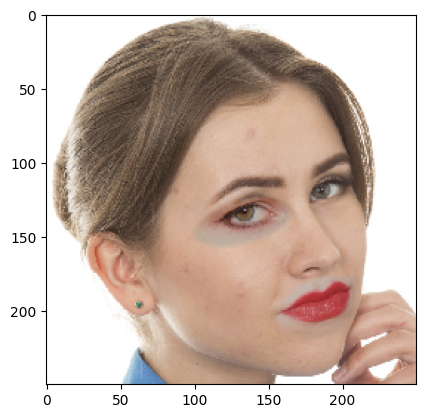

1/1 [==============================] - 0s 21ms/step

Actual: Fake
Predicted: Real

849.jpg


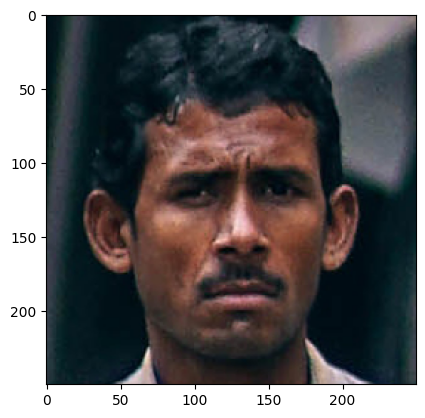

1/1 [==============================] - 0s 20ms/step

Actual: Real
Predicted: Fake

822.jpg


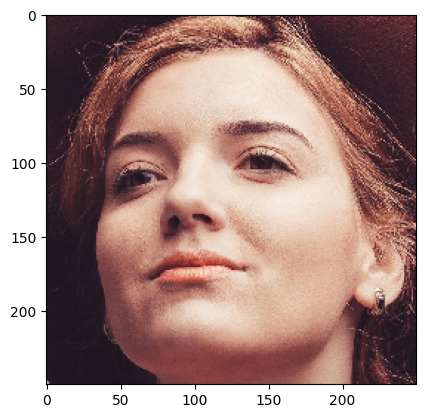

1/1 [==============================] - 0s 20ms/step

Actual: Real
Predicted: Real

fake_36.jpg


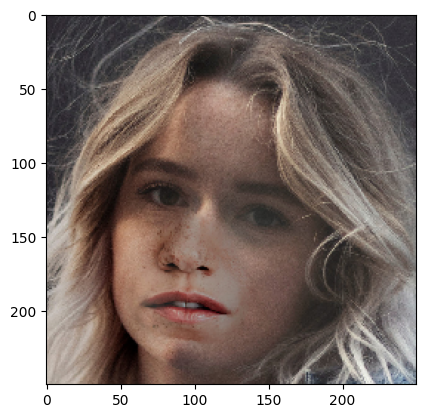

1/1 [==============================] - 0s 20ms/step

Actual: Fake
Predicted: Fake

846.jpg


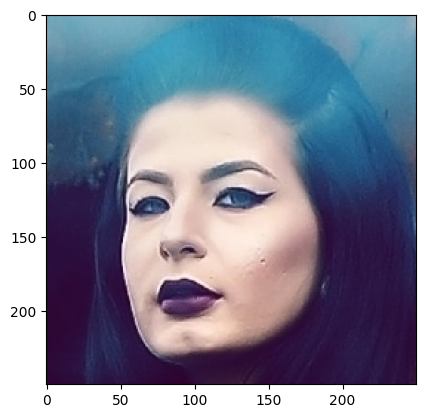

1/1 [==============================] - 0s 19ms/step

Actual: Real
Predicted: Fake

fake_497.jpg


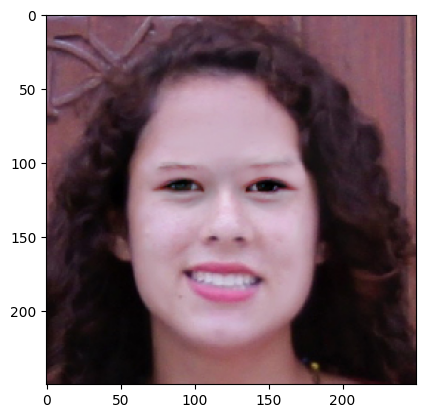

1/1 [==============================] - 0s 20ms/step

Actual: Fake
Predicted: Real

890.jpg


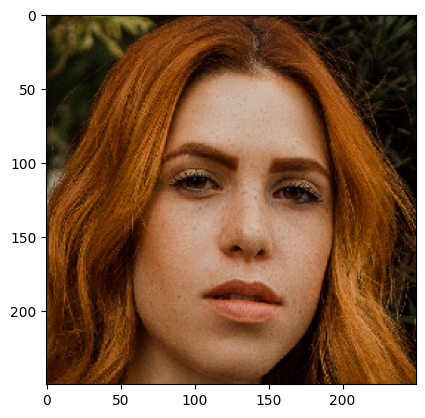

1/1 [==============================] - 0s 20ms/step

Actual: Real
Predicted: Fake

fake_523.jpg


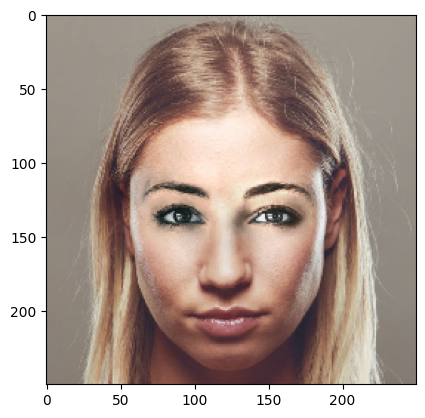

1/1 [==============================] - 0s 20ms/step

Actual: Fake
Predicted: Fake

778.jpg


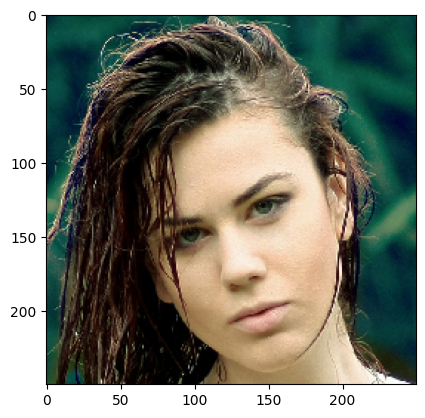

1/1 [==============================] - 0s 19ms/step

Actual: Real
Predicted: Fake

fake_277.jpg


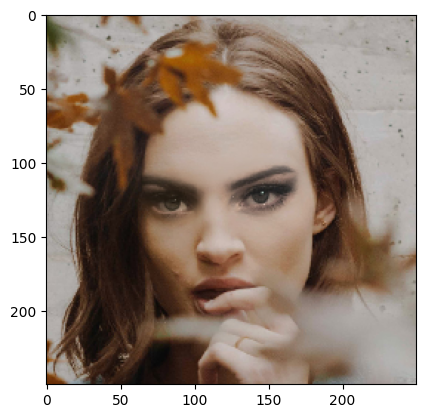

1/1 [==============================] - 0s 19ms/step

Actual: Fake
Predicted: Real



In [ ]:
# print("Total Test Images:", len(test_names), "\n")

# # test_dir = os.listdir(temp_folder)
# # random.shuffle(test_names)
# test_list = test_names[:10]

# print(test_list)

# for i in test_list:
#   #first_char = i[0:]
#   print(i)
#   test_img = image.load_img(test_folder + i, target_size=(HEIGHT,WIDTH))
#   plt.imshow(test_img)
#   plt.show()

#   x_test = image.img_to_array(test_img)
#   x_test = np.expand_dims(x_test, axis=0)
#   images = np.vstack([x_test])

#   #file_name = test_names[i]
#   filename_without_extension = os.path.splitext(i)[0]
#   #filename_without_extension = file_name.split('.')[0]

#   val = model.predict(images)
#   # Print actual value (real vs fake)
#   # check_name = int(filename_without_extension)
#   if filename_without_extension[0].isdigit():
#     print("\nActual: Real")
#   else:
#     print("\nActual: Fake")

#   # Print trained prediction value (real vs fake)
#   if val == 0:
#     print("Predicted: Fake\n")
#   else:
#     print("Predicted: Real\n")


In [ ]:
# class CustomImageDataGenerator(ImageDataGenerator):
#     def flow_from_directory(self, directory, print_interval=1, shuffle_files=True, **kwargs):
#         # Call the parent class method
#         generator = super().flow_from_directory(directory, **kwargs)
#         counter = 0
#         while True:
#           # Get the next batch
#           batch_x, batch_y = next(generator)
#           if counter % print_interval == 0:
#             # Get the file paths of the batch
#             file_paths = generator.filepaths
#             # Extract file names or subfolder names
#             file_names = [os.path.basename(path) for path in file_paths]
#             subfolder_names = [os.path.basename(os.path.dirname(path)) for path in file_paths]
#             # Print them out for the selected range
#             # if counter >= int(print_start) and counter < int(print_end):
#             plt.figure(figsize=(10, 10))
#             for i in range(len(batch_x)):
#               plt.subplot(4, 4, i + 1)
#               plt.imshow(batch_x[i], aspect="auto")
#               plt.title(f"Type: {subfolder_names[i].capitalize()}\nFile: {file_names[i]}")

#             plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
#             plt.show()
#           counter += 1
#           # Yield the augmented batch
#           yield batch_x, batch_y

# class CustomImageDataGenerator(ImageDataGenerator):
#     def flow_from_directory(self, directory, print_interval=1, shuffle_files=True, **kwargs):
#         # Call the parent class method
#         generator = super().flow_from_directory(directory, **kwargs)

#         counter = 0
#         while True:
#             # Get the next batch
#             batch_x, batch_y = next(generator)

#             # Get the file paths of the batch
#             file_paths = generator.filepaths
#             # Shuffle file paths if necessary
#             if shuffle_files:
#                 random.shuffle(file_paths)

#             # Extract file names or subfolder names
#             file_names = [os.path.basename(path) for path in file_paths]
#             subfolder_names = [os.path.basename(os.path.dirname(path)) for path in file_paths]
#             images = [os.path.join(directory, path) for path in file_paths]
#             images = [load_img(image, target_size=generator.target_size, interpolation=generator.interpolation) for image in images]
#             images = [img_to_array(image) for image in images]

#             if counter % print_interval == 0:
#                 plt.figure(figsize=(10, 10))
#                 num_images = min(len(images), 16)
#                 for i in range(num_images):
#                     plt.subplot(4, 4, i % 16 + 1)  # Use modulo operator to wrap around the index
#                     plt.imshow(images[i].astype(np.uint8), aspect="auto")
#                     plt.title(f"Type: {subfolder_names[i].capitalize()}\nFile: {file_names[i]}")
#                 plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
#                 plt.show()

#             counter += 1
#             # Yield the augmented batch
#             yield batch_x, batch_y

# batch = train_gen.next()
# plt.figure(figsize=(10, 10))

# for j in range(16):
#     # Load the image from the file path
#     img_path = batch[j]
#     img = load_img(img_path, target_size=(HEIGHT, WIDTH))

#     # Convert the image to a NumPy array
#     img_array = img_to_array(img)

#     # Normalize the image
#     img_array /= 255.0

#     # Display the image
#     plt.subplot(4, 4, j+1)
#     plt.imshow(img_array, aspect="auto")

# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
# plt.show()


# img_tensor = keras.preprocessing.image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)

# img_path = train_gen.filepaths[0]
# img = keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
#plt.imshow(img)

# img = np.expand_dims(img, axis=0)

#Creates our batch of one image
# pic = data_generator.flow(img)

# train_gen.shuffle = False
# train_gen.index_array = train_gen.index_array[0:4]
# #print(train_gen.index_array)
# print(train_gen.class_indices)

  # plt.subplot(4, 4, j+1)
  # # Get class of augmented_image
  # plt.imshow(augmented_image, aspect="auto")
  # if class_index == 1:
  #   class_name = 'Real'
  # else:
  #   class_name = 'Fake'
  # plt.title(class_name)



  # plt.subplot(4, 4, j+1)
  # plt.imshow(augmented_image, aspect="auto")
  # if class_index == 1:
  #   class_name = 'Real'
  # else:
  #   class_name = 'Fake'
  # plt.title(class_name)

#for i in range(1):
  # Get a batch of images
  #image = pic.next()
  #augmented_image = image
  # for j in range(16):
  #   image = pic.next()
  #   plt.subplot(4, 4, j+1)
  #   name = image[0]
  #   plt.imshow(image, aspect="auto")
  #   if str(name) == '1.1':
  #     plt.title('Real')
  #   else:
  #     plt.title('Fake')


Found 5600 images belonging to 2 classes.


KeyboardInterrupt: 

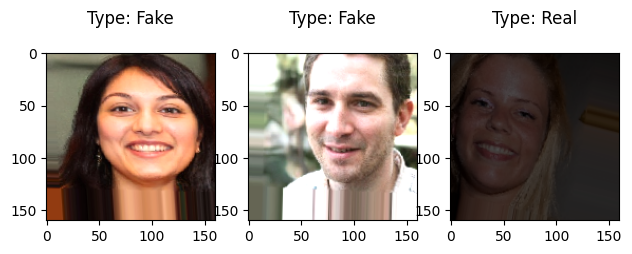

In [ ]:
# from keras.preprocessing.image import load_img, img_to_array

# # Creates an instance of ImageDataGenerator
# # 255 = max pixel density value for RGB color space
# # Rescale to normalize it and fit [0,1]

# img_folders = os.path.join(main_folder + "/largedataset/train/")
# SIZE_BATCH = 16

# #data_generator = CustomImageDataGenerator(
# data_generator = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range = 50,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     zoom_range = 0.1,
#     validation_split = 0.2,
#     brightness_range=[0.2, 1.5],
#     shear_range=20,
#     fill_mode = 'nearest',
#     horizontal_flip = True
# )


# # Load images from directory by creating a generator
# train_gen = data_generator.flow_from_directory(
#     directory = img_folders,
#     target_size = (HEIGHT, WIDTH),
#     batch_size = int(SIZE_BATCH),
#     class_mode = 'binary',
#     shuffle = True,
#     subset='training'
# )



# # Get file paths directly from generator
# #file_paths = train_gen.filenames

# # Shuffle file paths
# #random.shuffle(file_paths)

# # Display augmented images
# plt.figure(figsize=(10, 10))
# for i in range(16):
#     batch = train_gen.next()
#     #file_paths = train_gen.filepaths
#     augmented_image = batch[0][i]
#     label = batch[1][i]

#     plt.subplot(4, 4, i % 16 + 1)
#     plt.imshow(augmented_image, aspect="auto")
#     #class_index = img[1][0]       # Access the class index from batch[1]
#     #file_name = os.path.basename(file_paths[i])
#     if label == 1:
#       label = 'Real'
#     else:
#       label = 'Fake'
#     plt.title(f"Type: {label}\n")

#     # image_path = os.path.join(img_folders, file_paths[i])
#     # image = load_img(image_path, target_size=train_gen.target_size, interpolation=train_gen.interpolation)
#     # image_array = img_to_array(image)
#     # plt.subplot(4, 4, i % 16 + 1)  # Use modulo operator to wrap around the index
#     # plt.imshow(image_array.astype(np.uint8), aspect="auto")

#     # # Extract class and file names
#     # subfolder_name = os.path.basename(os.path.dirname(file_paths[i])).capitalize()
#     # file_name = os.path.basename(file_paths[i])
#     # plt.title(f"Type: {subfolder_name}\nFile: {file_name}")

# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.4)
# plt.show()

# # #Display the augmented images
# # batch = next(train_gen)
# # plt.figure(figsize=(10, 10))


# # for j in range(1):
# #   file_paths = train_gen.filepaths
# #   print(file_paths)
# #   # Shuffle file paths if necessary
# #   path = random.shuffle(file_paths)
# #   # Shuffle file paths if necessary
# #   #augmented_image, label = train_gen.next()[0][0], train_gen.next()[1][0]
# #   augmented_image = batch[0][j]
# #   class_index = batch[1][j]       # Access the class index from batch[1]

# #   file_names = [os.path.basename(path) for path in file_paths]
# #   subfolder_names = [os.path.basename(os.path.dirname(path)) for path in file_paths]
# #   image_label = [os.path.join(subfolder_names[i], file_names[i]) for i in range(16)]
# #   images_path = [os.path.join(img_folders, image_label[i]) for i in range(len(image_label))]
# #   img_view = [load_img(image, target_size=train_gen.target_size, interpolation=train_gen.interpolation) for image in images_path]
# #   images = [img_to_array(image) for image in img_view]

# #   for i in range(16):
# #     plt.subplot(4, 4, i % 16 + 1)  # Use modulo operator to wrap around the index
# #     plt.imshow(images[i].astype(np.uint8), aspect="auto")
# #     plt.title(f"Type: {subfolder_names[i].capitalize()}\nFile: {file_names[i]}")


# # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# # plt.show()



In [ ]:

# # Load images from directory by creating a generator
# train_gen = data_generator.flow_from_directory(
#     directory = img_folders,
#     target_size = (HEIGHT, WIDTH),
#     batch_size = BATCH_SIZE,
#     class_mode = 'binary',
#     shuffle = True,
#     subset='training'
# )

# validate_gen = data_generator.flow_from_directory(
#     directory = img_folders,
#     target_size = (HEIGHT, WIDTH),
#     batch_size = BATCH_SIZE,
#     class_mode = 'binary',
#     shuffle = False,
#     subset='validation'
# )

Found 1032 images belonging to 2 classes.
Found 257 images belonging to 2 classes.


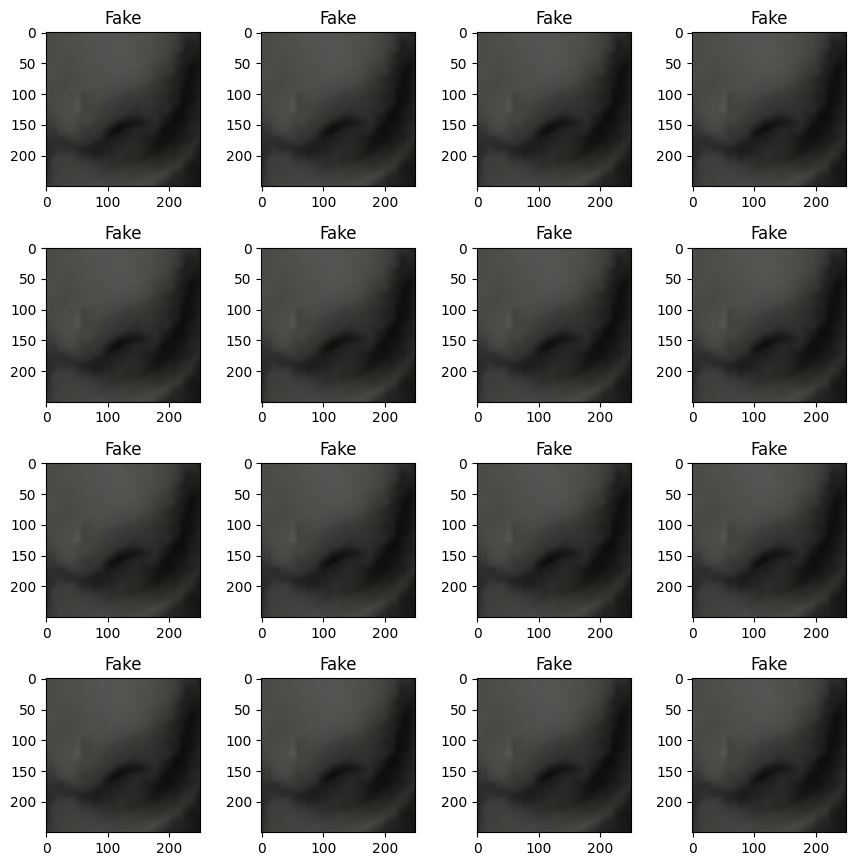

In [ ]:
# # image = keras.utils.load_img(
# #     img_folders,
# #     color_mode="rgb"
# # )
# # # for i in range(1):
# # #   img, label = train_gen.next()
# # #   img = keras.preprocessing.image.load_img(
# # #   target_size=(100,100)
# # #   )
# # img = keras.preprocessing.image.load_img(image)
# # img_tensor = keras.preprocessing.image.img_to_array(img)
# # img_tensor = np.expand_dims(img_tensor, axis=0)

# # #Creates our batch of one image
# # pic = data_generator.flow(img_tensor, batch_size =1)

# img_path = train_gen.filepaths[0]
# img = keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
# img_tensor = keras.preprocessing.image.img_to_array(img)
# img_tensor = np.expand_dims(img_tensor, axis=0)


# # Display the augmented images
# plt.figure(figsize=(10, 10))
# for i in range(1):
#   # Get a batch of images
#   image = next(train_gen)
#   augmented_image = image[0][0]
#   for j in range(16):
#     plt.subplot(4, 4, j + 1)
#     plt.imshow(augmented_image)
#     name = plt.title(image[1][0])
#     if name == '1.1':
#       plt.title('Real')
#     else:
#       plt.title('Fake')


# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# plt.show()

# #Plots our figures
# # for i in range(1,17):
# #   plt.subplot(3, 3, i)
# #   target_size = (HEIGHT, WIDTH),
# #   batch = train_gen.next()
# #   image_ = batch[0]
# #   augmented_image = batch(
# #     tf.expand_dims(image_, axis=0),
# #     #training=True
# #   )
# #   plt.imshow(augmented_image[0])
# #   plt.axis("off")
# #   plt.show()


# # for img, label in train_gen(1):
# #   plt.figure(figsize=(10, 10))
# #   first_image = train_gen[0]
# #   print(img.shape)
# #   for i in range(9):
# #     ax = plt.subplot(3, 3, i+1)
# #     augmented_image = data_generator(
# #         tf.expand_dims(first_image, axis=0),
# #         training=True
# #     )
# #     plt.imshow(augmented_image[0].numpy().astype("int32"))
# #     plt.title(label[0])
# #     plt.axis("off")

# # for _ in range(9):
# #   plt.figure(figsize=(10, 10))
# #   first_img = img[0]
# #   for i in range(9):
# #     ax = plt.subplot(3, 3, i+1)
# #     augmented_image = data_generator(
# #         tf.expand_dims(first_img, axis=0),
# #         training=True
# #     )
# #     plt.title(labels[i])
# #     plt.imshow(augmented_image[0].numpy("int32"))
# #     plt.axis("off")

In [ ]:
# # Create Tensorflow Model for CNN
# model = tf.keras.models.Sequential([
#   ## FIRST CONVOLUTION LAYER AND MAX POOLING
#   # Convolution Layer: 16 filters, kernel size = 3, using ReLu, specified input size and channels
#   tf.keras.layers.Conv2D(CONV1_FILTERS, kernel_size = 3, activation=tf.nn.relu, input_shape=(HEIGHT, WIDTH, 3)),
#   # Max Pooling: down-sampling; kernel size = 2, strides = 2
#   tf.keras.layers.MaxPool2D(2, strides = 2),

#   ## SECOND CONVOLUTION LAYER AND MAX POOLING
#   # Convolution Layer: 32 filters, kernel size = 3, using ReLu
#   tf.keras.layers.Conv2D(CONV2_FILTERS, kernel_size = 3, activation=tf.nn.relu),
#   # Max Pooling: down-sampling; kernel size = 2, strides = 2
#   tf.keras.layers.MaxPool2D(2, strides = 2),

#   ## THIRD CONVOLUTION LAYER; 64 filters
#   tf.keras.layers.Conv2D(CONV3_FILTERS, kernel_size = 3, activation=tf.nn.relu),
#   tf.keras.layers.MaxPool2D(2, strides = 2),
#   ## FOURTH CONVOLUTION LAYER; 64 filters
#   tf.keras.layers.Conv2D(128, kernel_size = 3, activation=tf.nn.relu),
#   tf.keras.layers.MaxPool2D(2, strides = 2),
#   ## FIFTH CONVOLUTION LAYER; 64 filters
#   # tf.keras.layers.Conv2D(256, kernel_size = 3, activation=tf.nn.relu),
#   # tf.keras.layers.MaxPool2D(2, strides = 2),

#   ## FLATTEN DATA
#   # Flatten input to 1D vector for fully connected layer
#   tf.keras.layers.Flatten(),

#   ## DENSELY-CONNECTED NEURAL NETWORK
#   # Fully connected layer using densely-connected NN
#   tf.keras.layers.Dense(64, activation = 'relu'),
#   #tf.keras.layers.Dense(64, activation = 'relu'),

#   ## Regularization
#   # Prevents overfitting
#   tf.keras.layers.Dropout(rate = 0.1),

#   # Output layer, class prediction
#   # Uses binary classification (real vs fake)
#   tf.keras.layers.Dense(1, activation = 'sigmoid')
# ])

In [ ]:
# # Check class names and values
# print(train_gen.class_indices)


{'fake': 0, 'real': 1}


In [ ]:
# # Train the model

# history = model.fit(
#   train_gen,
#   steps_per_epoch = len(train_gen),
#   epochs=20,
#   validation_data = validate_gen,
#   validation_steps = len(validate_gen)
# )


Epoch 1/20
33/33 [==============================] - 21s 644ms/step - loss: 0.0823 - accuracy: 0.9719 - val_loss: 0.0668 - val_accuracy: 0.9844
Epoch 2/20
33/33 [==============================] - 19s 564ms/step - loss: 0.0767 - accuracy: 0.9680 - val_loss: 0.0663 - val_accuracy: 0.9767
Epoch 3/20
33/33 [==============================] - 19s 566ms/step - loss: 0.0551 - accuracy: 0.9797 - val_loss: 0.0859 - val_accuracy: 0.9767
Epoch 4/20
33/33 [==============================] - 19s 563ms/step - loss: 0.0600 - accuracy: 0.9729 - val_loss: 0.1100 - val_accuracy: 0.9689
Epoch 5/20
33/33 [==============================] - 19s 565ms/step - loss: 0.0942 - accuracy: 0.9729 - val_loss: 0.0817 - val_accuracy: 0.9767
Epoch 6/20
33/33 [==============================] - 19s 569ms/step - loss: 0.0765 - accuracy: 0.9738 - val_loss: 0.0561 - val_accuracy: 0.9767
Epoch 7/20
33/33 [==============================] - 18s 562ms/step - loss: 0.0634 - accuracy: 0.9777 - val_loss: 0.0946 - val_accuracy: 0.9805

In [ ]:
# loss, accuracy = model.evaluate(train_gen)
# print(f"Test loss: {loss:.4f}")
# print(f"Test accuracy: {accuracy*100:.2f}%")

# print(history.history)

33/33 [==============================] - 17s 506ms/step - loss: 0.1275 - accuracy: 0.9535
Test loss: 0.1275
Test accuracy: 95.35%
{'loss': [0.08226598054170609, 0.07667136192321777, 0.05512841418385506, 0.0599871501326561, 0.09420694410800934, 0.07647164911031723, 0.06335102021694183, 0.0741623193025589, 0.05991174280643463, 0.06794506311416626, 0.06515297293663025, 0.06745488196611404, 0.07085404545068741, 0.06886278837919235, 0.06798984855413437, 0.09374858438968658, 0.11228064447641373, 0.08600472658872604, 0.07977977395057678, 0.06845451891422272], 'accuracy': [0.9718992114067078, 0.9680232405662537, 0.979651153087616, 0.9728682041168213, 0.9728682041168213, 0.9738371968269348, 0.9777131676673889, 0.9718992114067078, 0.9786821603775024, 0.9767441749572754, 0.9806201457977295, 0.9767441749572754, 0.9777131676673889, 0.9748061895370483, 0.9689922332763672, 0.9651162624359131, 0.963178277015686, 0.9738371968269348, 0.9689922332763672, 0.9699612259864807], 'val_loss': [0.06678445637226